# Sentence Splitting
This notebook uses OCRed text for a volume year and splits it into sentences using regular expression pattern matching.<br>
For this notebook to run, there should be an OCRed folder that should contain a .txt file, a .tsv file, and an images sub-folder (more details in the notebook).

<b>Note:</b>
- If the Acts and Joints were mixed for the chosen year, the OCRed output will contain `{year}_Both.txt` and `{year}_Both_data.tsv`
- If the Acts and Joints were seperate for the chosen year, the OCRed output will contain `{year}_Acts.txt` and `{year}_Acts_data.tsv`

In [1]:
from nltk.tokenize import PunktSentenceTokenizer
import pandas as pd
import matplotlib.pyplot as plt
from os import listdir
import re
import numpy as np

pd.set_option('display.max_colwidth', None)

<br>
Either get the year variable from elsewhere (such as when this notebook is accessed from another file) or specify the year.

In [2]:
# Get the year variable from somewhere else
%store -r year

In [3]:
# # If running this notebook independently,
# # Uncoment the following line of code
# year = 1893

In [4]:
# This is the directory that will contain the OCRed output:
dir_OCR = "/Users/nitingupta/Desktop/OTB/OCRed/" + str(year)

print(f"Working on {year} under {dir_OCR}")

Working on 1901 under /Users/nitingupta/Desktop/OTB/OCRed/1901


In [5]:
# Try reading in "{year}_text.txt" if the Acts and Joints were seperate for the year
try:
    acts_path = dir_OCR + "/" + str(year) + "_Acts.txt"
    with open(acts_path, 'r') as f:
        data = f.read()

    # If the read is successful, set a flag that identifies that the Acts and Joints are seperate
    actsSep = True

# However, if the directory contains {year}_Both.txt instead, a FileNotFoundError will be returned for the above code.
# So, catch that error and read in "{year}_Both.txt"
except FileNotFoundError:
    acts_path = dir_OCR + "/" + str(year) + "_Both.txt"
    with open(acts_path, 'r') as f:
        data = f.read()
    
    actsSep = False  # The flag being False means that the Acts and Joints are not seperate

# This variable holds all the OCRed text as a String
# data

In [6]:
print("The number of pages OCRed for {year} is: {count}".format(year = year, count = (data.count("\n\n")+1)))

The number of pages OCRed for 1901 is: 258


<br>

## A. Training the tokenizer
Based on this [article](https://subscription.packtpub.com/book/application-development/9781782167853/1/ch01lvl1sec12/training-a-sentence-tokenizer),
- NLTK's default sentence tokenizer is general purpose and usually works quite well. But sometimes it might not be the best choice for our text if it uses nonstandard punctuation or is formatted in a unique way. In such cases, training your own sentence tokenizer can result in much more accurate sentence tokenization.
- The `PunktSentenceTokenizer` class uses an unsupervised learning algorithm to learn what constitutes a sentence break.
    - The specific technique used in this case is called sentence boundary detection. It works by counting punctuation and tokens that commonly end a sentence, such as a period or a newline, then using the resulting frequencies to decide the sentence boundaries.

In [7]:
sent_tokenizer = PunktSentenceTokenizer(data)
sentences = sent_tokenizer.tokenize(data)

# A List of tokens/sentences as seperated by nltk's PunktSentenceTokenizer
# sentences

<br>

## B. Creating the dataframe
Make a new dataframe with the sentences and lengths as a features.
<br>Other features will be added later.

In [8]:
# Add to a new DataFrame
df = pd.DataFrame()
df["sentence"] = sentences

In [9]:
# Strip sentences of trailing and leading whitespaces
df['sentence'] = df['sentence'].str.strip()

In [10]:
print("Length of the initial dataframe:", df.shape[0], "\nThis is the number of tokenized sentences.")

Length of the initial dataframe: 1864 
This is the number of tokenized sentences.


<br>

## C. Adding page file names
- Add an feature that specifies which page number that sentence starts and ends on.
- Reading only Acts. <b> Not reading Joints </b>
- The reason to read the files from the directory is to ensure that missing file pages are not missed in the dataframe.

In [11]:
# This is the path to the directory that contains the images.
# NOTE: This directory is inside the OCRed output for the chosen year
dir_imgs = dir_OCR + "/images"
print(f"The images directory is {dir_imgs}")

The images directory is /Users/nitingupta/Desktop/OTB/OCRed/1901/images


In [12]:
imgs = listdir(dir_imgs)
imgs = [img for img in imgs if "jpg" in img or "tiff" in img or "JPG" in img or "TIFF" in img]
imgs.sort()
print("The number of image files for this year is:", len(imgs))

The number of image files for this year is: 270


In [13]:
fileType = imgs[0].split(".")[1]
print(f"The files are of type: {fileType}")

The files are of type: jpg


<b>Note:</b>
- The OCR attempts to seperates new pages by adding "\n\n". However, the total number of pages does not equal the total count of "\n\n" in the text as the OCR does not add "\n\n" after every page.
- One way to eliminate this issue is by utilizing the `{year}_Both_data.tsv` (if acts and joints mixed) or `{year}_Acts_data.tsv` (if acts and joints seperated) file from the OCR output.
- This file contains each word (in the 2nd last column) and the filename for that word (last column).
- Also, since we are only working with Acts, if the Acts and Joints are seperate, the last word in the df_word dataframe will not end on the actual last page in the images sub-folder.

In [14]:
# Based on whether the Acts and Joints are mixed, read the appropriate tsv file
if actsSep:
    df_words = pd.read_table(f"{dir_OCR}/{year}_Acts_data.tsv")
else:
    df_words = pd.read_table(f"{dir_OCR}/{year}_Both_data.tsv")

df_words

,left,top,width,height,conf,text,name
0,0,0,1592,2536,-1.000000,NaN,00035.jpg
1,728,283,60,144,-1.000000,NaN,00035.jpg
2,728,257,180,170,-1.000000,NaN,00035.jpg
3,728,283,60,144,-1.000000,NaN,00035.jpg
4,728,283,60,144,34.161140,IK,00035.jpg
...,...,...,...,...,...,...,...
127981,682,1851,38,31,95.772659,of,00292.jpg
127982,735,1851,174,39,96.576187,"February,",00292.jpg
127983,926,1851,40,31,92.059761,A.,00292.jpg
127984,984,1851,39,31,92.059761,D.,00292.jpg


So, to label the page numbers in the dataframe, we can go through the original dataframe and find the start and end words in each sentence.
<br>We, can then find the page numbers for those words, from `df_words` and add them to the original dataframe, `df`.
<br>To start, we need to clean the two dataframes.

In [15]:
df['page'] = np.nan

# Drop the columns which are unessecary for our analysis
df_words.drop(columns=["left", "top", "width", "height", "conf"], inplace=True)

# Drop the rows which don't contain a word in the "text" column
df_words.dropna(inplace=True)

# Relabel the "name" column to "page" column
df_words.rename(columns={"name": "page"}, inplace=True)

# Reassign index after dropping nas
df_words = df_words.assign(row_number=range(len(df_words)))
df_words.set_index('row_number', inplace=True)

# Drop the 'page' column from the org dataframe
df.drop(columns=['page'], inplace=True)

# Add an empty 'start_page' and 'end_page' column
df['start_page'] = np.nan
df['end_page'] = np.nan

Since, a word can only exist on a single page, we have unique identifiers for the start and end page for each sentence 

In [16]:
# Tracker for df_words:
words_trkr = 0

# Loop over the original dataframe
for i in range(0, df.shape[0]):
    
    # Remove "\n\n" from the original dataframe as they will interfere with the analysis
    df.at[i, 'sentence'] = df.iloc[i]['sentence'].replace("\n\n", "")

    # For each sentence, extract the first and last word
    tmp_sentence = df.iloc[i]['sentence'].split(" ")
    start, last = tmp_sentence[0], tmp_sentence[-1]

    # Get the page number for the start and end word
    start_page = df_words.iloc[words_trkr]['page']

    try:
        end_page = df_words.iloc[words_trkr + len(tmp_sentence)]['page']
    except:
        end_page = df_words.iloc[words_trkr]['page']
        

    # Remove the filename from the pages:
    start_page = start_page.split(".")[0]
    end_page = end_page.split(".")[0]

    
    # Assign the page number to their respective columns in the dataframe
    df.at[i, 'start_page'] = start_page
    df.at[i, 'end_page'] = end_page
    
    # Update tracker
    words_trkr += len(tmp_sentence)

In [17]:
df.tail()

,sentence,start_page,end_page
1859,"SECTION 1. Be it enacted by the General Assembly of the State of South Carolina: That the County Board of Commis- sioners of Cherokee County be, and they are hereby, authorized, if in their discretion they deem that it is for the best interest of said County, to borrow a sum of money from the Sinking Fund of the State of South Carolina, not to exceed ten thousand dol- lars, at a rate of interest not to exceed five per centum per an- num, for the purpose of building a bridge across Broad River, in said County, at such point on said river as they may deem most practicable, and a special tax of one-half mill on the dollar may be levied on all taxable property in the County of Chero- kee, provided the Board of Commissioners so decide to build said bridge, for the said period of seven years, for the purpose of repaying said loan.",00292,00292
1860,"That the proceeds of said levy of one- half mill shall be paid each year on said loan until the seventh year, in which year the balance remaining due on said loan shall be paid from said special levy, if any remain it shall-be turned into the County Treasury for ordinary County purposes, and if a’sufficient sum has not been realized by said special levy at the expiration of said seven years the deficiency shall be paid by the County Board of Commissioners out of the ordinary County funds.",00292,00292
1861,Sec. 2.,00292,00292
1862,"That the Commissioners of the Sinking Fund of the State of South Carolina are hereby authorized to lend to the County Board of Commissioners of Cherokee County out of the funds in their hands, the sum of ten thousand dollars, to be used for building said bridge, said sum to be secured by the special levy as herein provided for in Section one.",00292,00292
1863,"Approved the 2oth day of February, A. D. 1goI.",00292,00292


<br>

## D. Further Cleaning and Regex
Remove unecessary words in the sentences which do not contribute to the overall meaning.

In [18]:
# New dataframe so that the results of the matching can be compared
df_cleaned = df.copy()

# A new dictionary to keep track of the number of errors
errorsDict = {}

In [19]:
# Create a new column that will contain the removed words that match the section patter
df_cleaned['removed'] = np.nan

# Rename 'sentence' column to 'org_sent' to avoid confusion
df_cleaned.rename(columns={'sentence': 'org_sent'}, inplace=True)

In [20]:
df_cleaned.head()

,org_sent,start_page,end_page,removed
0,IK OF THE | GENERAL ASSEMBLY.,00035,00035,NaN
1,"OF THE STATE OF SOUTH CAROLINA Passed at the Regular Session which was begun and held at the City of Co- lumbia on the Eighth Day of January, A. D. 1961 and was adjourned without day on the Sicteenth day of February, A. D. 1901.",00035,00035,NaN
2,"M. B. McSweeney, Governor.",00035,00035,NaN
3,"Jas. H. TittMan, Lieutenant- Governor and ex officio President of the Senate.",00035,00035,NaN
4,"W. F STEVENSON, Speaker of the House of Representatives Rorert R. HEMPHILL, Clerk of the Senate.",00035,00035,NaN


In [21]:
def replaceInDF(rgx_match: re.Pattern, df: pd.DataFrame, prevAppend: bool):
    '''
    Find the provided regex pattern in the provided dataframe.
    
    Parameters
    ----------
    rgx_match : re.Pattern
        A regular expression pattern that will be search for and replaced in the df
    df: pandas.Dataframe
        A Pandas dataframe to search and replace for
        Should contain an:
            'org_sent' column, in which the matches which will be replaced
             'removed' column, in which the matched string will be stored
     prevAppend: bool
         A flag for whether the match should be append to the end of the previous sentence
        
    Returns
    -------
    A tuple consisting of:
    
    df: pandas.Dataframe
        The modified Dataframe with the matches performed
    errorCount: int
        A count of how many times this error was found.
    '''
    
    errorCount = 0
    
    for i in range(0, df.shape[0]):
    
        # The value at this row's "removed" column
        removed_val = df.iloc[i]['removed']
        
        # The found matches
        matches = "; ".join([x.group() for x in re.finditer(rgx_match, df.iloc[i]['org_sent'])])
        
        # if no match found...
        if not matches:
            continue

        # Else if match is found...
        
        # Update the counter for the error with the number of matches found
        errorCount += len(matches.split(";"))
        
        # Check if there is already a value in the 'removed' column for that row
        if removed_val != "" and not pd.isnull(removed_val):
            # Append the matches to the existing value seperated by ";"
            df.at[i, 'removed'] = str(removed_val) + "; " + matches
        else:
            # Add the matched patterns to the "removed" section seperated by ";"
            df.at[i, 'removed'] = matches
        
        if prevAppend and i != 0:
            
            m = re.search(rgx_match, df.iloc[i]['org_sent'])
            if m:
                # Add to the end of the previous sentence
                df.at[i-1, 'org_sent'] = df.iloc[i-1]['org_sent'] + " " + str(m.group())
            
        # Remove the matched patterns from sentences
        df.at[i, 'org_sent'] = re.sub(rgx_match, '', df.iloc[i]['org_sent'])    
        
    return df, errorCount

<br>

### 1. Removing section identifiers
The following code implements regex patterns to identify sections, such as "Section 1.", "Sec. 4.", etc. 
<br>Since most sections, which need to be removed, appear either at the start or the start of the ORCed sentence, the pattern finds matches either at the start or the end of the sentence.
<br>Do note that the same pattern is repeated for the start and end of the sentence, and is seperated by '|'.

Some notes about the pattern:
- `r'(S|s|E|e|C|c|T|t|I|i|O|o|N|n){2,}'` matches "Section"
- `r'(\.|,|:|;| )'{0,2}` matches mistaken delimiters or spaces following "Section"
- `r'[0Oo1Iil!2Z5S6G\d]{1,2}'` matches the section number. Letters are required in this pattern to account for OCR mistakes
- `r'(. |.| |)'` matches the end of phrase spaces and periods

In [22]:
rgx_match = re.compile(r"^(S|s|E|e|C|c|T|t|I|i|O|o|N|n){2,}(\.|,|:|;| ){0,2}[0Oo1Iil!2Z5S6G\d]{1,2}(. |.| |)|(S|s|E|e|C|c|T|t|I|i|O|o|N|n){2,}(\.|,|:|;| ){0,2}[0Oo1Iil!2Z5S6G\d]{1,2}(. |.| |)$")

df_cleaned, errorsDict['section identifiers'] = replaceInDF(rgx_match, df_cleaned, False)

In [23]:
df_cleaned.head(10)

,org_sent,start_page,end_page,removed
0,IK OF THE | GENERAL ASSEMBLY.,00035,00035,NaN
1,"OF THE STATE OF SOUTH CAROLINA Passed at the Regular Session which was begun and held at the City of Co- lumbia on the Eighth Day of January, A. D. 1961 and was adjourned without day on the Sicteenth day of February, A. D. 1901.",00035,00035,NaN
2,"M. B. McSweeney, Governor.",00035,00035,NaN
3,"Jas. H. TittMan, Lieutenant- Governor and ex officio President of the Senate.",00035,00035,NaN
4,"W. F STEVENSON, Speaker of the House of Representatives Rorert R. HEMPHILL, Clerk of the Senate.",00035,00035,NaN
5,"T. C. Hamer, Clerk of the House of Representatives.",00035,00035,NaN
6,"ro, = PART I. GENERAL AND PERMANENT LAWS- _ No.",00035,00035,NaN
7,344. AN ACT to Grant To THE City CouncIL oF CHARLESTON AND ITS SUCCESSORS THE TITLE AND INTEREST OF THE STATE TO CERTAIN LANDS IN CHARLESTON COUNTY FOR THE PURPOSES OF A NAVAL STATION.,00035,00035,NaN
8,"Be it enacted by the General Assembly of the State of South Carolina : That the right, title and interest of the State to the following described tract or parcel of land and land covered with water situated in the County of Charleston in this State be, and the same is hereby granted and ceded to “All that the City Council of Charleston and its successors: tract or parcel of land and land covered with water situate ly- ing and being on the west bank of the Cooper River, in the County of Charleston in this State; measuring and containing seven hundred and sixty acres more or less, butting and bound- ing to the North by lands of Mrs. W. W. Lawton and by the Cooper River, on the East by Cooper River, on the South by Ship Yard Creek and on the West by Ship Yard Creek, as is delineated on a map of the city of Charleston and vicinity made by J. H. Dingle, City Surveyor, December 1900.”",00035,00036,SECTION 1. ; SEc. 2.
9,"The grant herein made is upon the express condi- tion that the City Council of Charleston shall convey, in fee simple to the United States of America, the said tract or parcel of land hereinbefore referred to in Section 1 of this Act for the site, location and purposes of a naval station.",00036,00036,NaN


<br>

### 2. Removing end of line hyphenation
Whenever a word in the sentence continues from the end of a line to the beginning of the next line and is joined by a hyphen, the OCRed sentence also contains that hyphen and a space.
<br>For example, 'Commander-in-Chief' is OCRed as 'Com- mander-in-Chief'
<br>The following code implements regex patterns to remove "- " in the text since each hyphenated word is split with "- ".

In [24]:
rgx_match = re.compile('[-][ ]')
df_cleaned, errorsDict['EOL hyphenation'] = replaceInDF(rgx_match, df_cleaned, False)

In [25]:
df_cleaned.head(10)

,org_sent,start_page,end_page,removed
0,IK OF THE | GENERAL ASSEMBLY.,00035,00035,NaN
1,"OF THE STATE OF SOUTH CAROLINA Passed at the Regular Session which was begun and held at the City of Columbia on the Eighth Day of January, A. D. 1961 and was adjourned without day on the Sicteenth day of February, A. D. 1901.",00035,00035,-
2,"M. B. McSweeney, Governor.",00035,00035,NaN
3,"Jas. H. TittMan, LieutenantGovernor and ex officio President of the Senate.",00035,00035,-
4,"W. F STEVENSON, Speaker of the House of Representatives Rorert R. HEMPHILL, Clerk of the Senate.",00035,00035,NaN
5,"T. C. Hamer, Clerk of the House of Representatives.",00035,00035,NaN
6,"ro, = PART I. GENERAL AND PERMANENT LAWS_ No.",00035,00035,-
7,344. AN ACT to Grant To THE City CouncIL oF CHARLESTON AND ITS SUCCESSORS THE TITLE AND INTEREST OF THE STATE TO CERTAIN LANDS IN CHARLESTON COUNTY FOR THE PURPOSES OF A NAVAL STATION.,00035,00035,NaN
8,"Be it enacted by the General Assembly of the State of South Carolina : That the right, title and interest of the State to the following described tract or parcel of land and land covered with water situated in the County of Charleston in this State be, and the same is hereby granted and ceded to “All that the City Council of Charleston and its successors: tract or parcel of land and land covered with water situate lying and being on the west bank of the Cooper River, in the County of Charleston in this State; measuring and containing seven hundred and sixty acres more or less, butting and bounding to the North by lands of Mrs. W. W. Lawton and by the Cooper River, on the East by Cooper River, on the South by Ship Yard Creek and on the West by Ship Yard Creek, as is delineated on a map of the city of Charleston and vicinity made by J. H. Dingle, City Surveyor, December 1900.”",00035,00036,SECTION 1. ; SEc. 2.; - ; -
9,"The grant herein made is upon the express condition that the City Council of Charleston shall convey, in fee simple to the United States of America, the said tract or parcel of land hereinbefore referred to in Section 1 of this Act for the site, location and purposes of a naval station.",00036,00036,-


<br>

### 3. Relocating incorrect "Approved ..." phrases
The “Approved…” phrases are incorrectly appended to the start of the next law. They should by appended to the end of the previous law.
<br>Phrases might be of the format: 
- "Approved the 2oth day of February, A. D. 1901",
- "Approved December 15th, A. D. 1892.",
- "Approved December O5th, A. D. 1892.",
- "Approved December !2th, A. D. 1892.",
- "Approved December 6Gth, A. D. 1892.",
- "Approved December 05th, A. D. 1892.",

Since phrases might either have the month or the date after the "Approved" sub-string, the code below utilized two patterns to account for either case, seperated by '|'.
<br>
Some notes about the pattern:
- `r'[0Oo1Iil!2Z5S6G\d]{1,2}'` matches the date. Letters are required in this pattern to account for OCR mistakes
- `r'(?:th|st|nd|rd)'` matches the prefixes for the dates
- `r'[A-Z][a-z]+'` matches the month
- `r'.{4}'` matches years
- `r'(. |.| |)'` matches the end of phrase spaces and periods

In [26]:
rgx_match = re.compile(
    r'^Approved the [0Oo1Iil!2Z5S6G\d]{1,2}(?:th|st|nd|rd) day of [A-Z][a-z]+, A\. D\. .{4}(. |.| |)\b|Approved [A-Z][a-z]+ [0Oo1Iil!2Z5S6G\d]{1,2}(?:th|st|nd|rd), A\. D\. .{4}(. |.| |)\b')
df_cleaned, errorsDict['Approved phrases'] = replaceInDF(rgx_match, df_cleaned, True)

In [27]:
df_cleaned.head(10)

,org_sent,start_page,end_page,removed
0,IK OF THE | GENERAL ASSEMBLY.,00035,00035,NaN
1,"OF THE STATE OF SOUTH CAROLINA Passed at the Regular Session which was begun and held at the City of Columbia on the Eighth Day of January, A. D. 1961 and was adjourned without day on the Sicteenth day of February, A. D. 1901.",00035,00035,-
2,"M. B. McSweeney, Governor.",00035,00035,NaN
3,"Jas. H. TittMan, LieutenantGovernor and ex officio President of the Senate.",00035,00035,-
4,"W. F STEVENSON, Speaker of the House of Representatives Rorert R. HEMPHILL, Clerk of the Senate.",00035,00035,NaN
5,"T. C. Hamer, Clerk of the House of Representatives.",00035,00035,NaN
6,"ro, = PART I. GENERAL AND PERMANENT LAWS_ No.",00035,00035,-
7,344. AN ACT to Grant To THE City CouncIL oF CHARLESTON AND ITS SUCCESSORS THE TITLE AND INTEREST OF THE STATE TO CERTAIN LANDS IN CHARLESTON COUNTY FOR THE PURPOSES OF A NAVAL STATION.,00035,00035,NaN
8,"Be it enacted by the General Assembly of the State of South Carolina : That the right, title and interest of the State to the following described tract or parcel of land and land covered with water situated in the County of Charleston in this State be, and the same is hereby granted and ceded to “All that the City Council of Charleston and its successors: tract or parcel of land and land covered with water situate lying and being on the west bank of the Cooper River, in the County of Charleston in this State; measuring and containing seven hundred and sixty acres more or less, butting and bounding to the North by lands of Mrs. W. W. Lawton and by the Cooper River, on the East by Cooper River, on the South by Ship Yard Creek and on the West by Ship Yard Creek, as is delineated on a map of the city of Charleston and vicinity made by J. H. Dingle, City Surveyor, December 1900.”",00035,00036,SECTION 1. ; SEc. 2.; - ; -
9,"The grant herein made is upon the express condition that the City Council of Charleston shall convey, in fee simple to the United States of America, the said tract or parcel of land hereinbefore referred to in Section 1 of this Act for the site, location and purposes of a naval station.",00036,00036,-


<br>

### 4. Removing Act seperators
The horizontal lines differentiating one Act from another show up as U+2014 : EM DASH characters (one or multiple) in the OCR.
<br>For example, '——- —— AN ACT...' or '—— AN ACT...'

Some notes about the pattern:
- `r'^—+'` matches one or more consecutive occurrences of the "—" character at the start of a line.
- `r'(?=\s*[A-Za-z])'` is a positive lookahead (this part isn't captured) that checks if there is zero or more whitespace characters (\s*) followed by a letter ([A-Za-z]) after the "—" characters.

In [28]:
rgx_match = re.compile(r'^—+(?=\s*[A-Za-z])')
df_cleaned, errorsDict['Act seperators'] = replaceInDF(rgx_match, df_cleaned, False)

In [29]:
df_cleaned.head()

,org_sent,start_page,end_page,removed
0,IK OF THE | GENERAL ASSEMBLY.,00035,00035,NaN
1,"OF THE STATE OF SOUTH CAROLINA Passed at the Regular Session which was begun and held at the City of Columbia on the Eighth Day of January, A. D. 1961 and was adjourned without day on the Sicteenth day of February, A. D. 1901.",00035,00035,-
2,"M. B. McSweeney, Governor.",00035,00035,NaN
3,"Jas. H. TittMan, LieutenantGovernor and ex officio President of the Senate.",00035,00035,-
4,"W. F STEVENSON, Speaker of the House of Representatives Rorert R. HEMPHILL, Clerk of the Senate.",00035,00035,NaN


<br>

### 5. Removing incorrect numbers at the start
Some numbers are incorrectly left at the start of the sentence from the OCR process. They are rather OCRed, for example, as 2, or 2.

Some notes about the pattern:
- `r'^[0Oo1Iil!2Z5S6G\d]{1,3}'` matches upto 3 numbers at the start of the string
- `r'(. |.| |)'` matches the end of phrase spaces and periods

In [30]:
rgx_match = re.compile(r'^[0Oo1Iil!2Z5S6G\d]{1,3}(. |.| |)')
df_cleaned, errorsDict['Incorrect starting nums'] = replaceInDF(rgx_match, df_cleaned, False)

In [31]:
df_cleaned.head()

,org_sent,start_page,end_page,removed
0,OF THE | GENERAL ASSEMBLY.,00035,00035,IK
1,"THE STATE OF SOUTH CAROLINA Passed at the Regular Session which was begun and held at the City of Columbia on the Eighth Day of January, A. D. 1961 and was adjourned without day on the Sicteenth day of February, A. D. 1901.",00035,00035,- ; OF
2,"M. B. McSweeney, Governor.",00035,00035,NaN
3,"Jas. H. TittMan, LieutenantGovernor and ex officio President of the Senate.",00035,00035,-
4,"W. F STEVENSON, Speaker of the House of Representatives Rorert R. HEMPHILL, Clerk of the Senate.",00035,00035,NaN


<br>

### 6. Removing session headers
For some volumes, the OCRed text includes information about the session held (which is usually found on the first page).
<br>The first valid sentence starts with "An Acts ...". So, to remove them, the code removes all sentences until the first valid sentence appears

In [32]:
disregarded = 0  # Count for the number removed

for i, sent in enumerate(df_cleaned['org_sent']):

    # If the sentence with "an" is found, exit the loop
    if sent.lower().strip().startswith("an"):
           break
    
    # Disregard the sentence since it does not start with "an"
    df_cleaned.drop(index=i, inplace=True)
    disregarded += 1

In [33]:
# Reset the index
df_cleaned.reset_index(drop=True, inplace=True)

In [34]:
print(f"Total number of sentences changed to disregarded: {disregarded}.")
errorsDict['Session headers'] = disregarded

Total number of sentences changed to disregarded: 7.


In [35]:
df_cleaned.head()

,org_sent,start_page,end_page,removed
0,AN ACT to Grant To THE City CouncIL oF CHARLESTON AND ITS SUCCESSORS THE TITLE AND INTEREST OF THE STATE TO CERTAIN LANDS IN CHARLESTON COUNTY FOR THE PURPOSES OF A NAVAL STATION.,00035,00035,344.
1,"Be it enacted by the General Assembly of the State of South Carolina : That the right, title and interest of the State to the following described tract or parcel of land and land covered with water situated in the County of Charleston in this State be, and the same is hereby granted and ceded to “All that the City Council of Charleston and its successors: tract or parcel of land and land covered with water situate lying and being on the west bank of the Cooper River, in the County of Charleston in this State; measuring and containing seven hundred and sixty acres more or less, butting and bounding to the North by lands of Mrs. W. W. Lawton and by the Cooper River, on the East by Cooper River, on the South by Ship Yard Creek and on the West by Ship Yard Creek, as is delineated on a map of the city of Charleston and vicinity made by J. H. Dingle, City Surveyor, December 1900.”",00035,00036,SECTION 1. ; SEc. 2.; - ; -
2,"The grant herein made is upon the express condition that the City Council of Charleston shall convey, in fee simple to the United States of America, the said tract or parcel of land hereinbefore referred to in Section 1 of this Act for the site, location and purposes of a naval station.",00036,00036,-
3,c. 3.,00036,00036,Sr
4,"That in case of the failure of the United States of America to locate, build or construct a Naval Station in the County of Charleston within the space of three years from the passage of this Act, then the title to said tract or parcel of land shall revert to the State.",00036,00036,NaN


<br>

### 7. Converting to uppercase
For some sentence, the OCR process outputs few words as a mix of upper and lower case letters. To help in producing human readable digitized text, the following piece of code detects and changes words to all uppercase.
<br>While this step might not be a priority for computational analysis, it is an important step to help improve the readability of the sentences
<br>An example, "AN ACT FoR THE PROTECTION OF THE AIDS TO NAVIGATION EsTABLISHED BY THE AUTHORITY OF THE UNITED STATES LicgHt Hovust BoarD WITHIN THE STATE OF SOUTH CAROLINA."

In [36]:
def upperIfNeeded(sentence, ratio = 0.50):
    '''
    Convert the given sentence list into an uppercase sentence list
    if the ratio of uppercase words (not including the ones with a mix of digits 
    or words like "SECTION") to the total words is greater than a fixed value.
    
    Parameters
    ----------
    sentence: str
         A str of sentence to check and convert to uppercase
        
    Returns
    -------
    sentence: str
        If check is approved the return an uppercase version of str.
        Else return the sentence.
    '''
    
    count = 0  # A count of the number of already uppercased words
    
    for word in sentence.split(" "):
        # Check whether the word consists of only letters,
        # has a length greater than 1, is uppercase, and 
        # isn't "SECTION"
        if word.isalpha() and len(word) > 1 and word.isupper() and word != "SECTION":
            count += 1

    # If the count to words ratio is greater
    if (count/len(sentence.split(" ")) > ratio):
        # Return all uppercase words
        return sentence.upper()        
    
    # Else, return the original sentence list
    return sentence

In [37]:
# Apply the above function to each sentence in 'org_sent'
# And store the output a new column named 'modified'
df_cleaned['modified'] = df_cleaned.apply(lambda x: upperIfNeeded(x['org_sent']), axis=1)

In [38]:
# Check if the original sentence has been converted to uppercase,
# and if it has, then add a boolean in a new column named 'flag'

df_cleaned['flag'] = np.where(df_cleaned['org_sent'] != df_cleaned['modified'], True, False)

In [39]:
# View the rows where the sentence has been converted to uppercase
df_cleaned[df_cleaned['flag'] == True]

,org_sent,start_page,end_page,removed,modified,flag
0,AN ACT to Grant To THE City CouncIL oF CHARLESTON AND ITS SUCCESSORS THE TITLE AND INTEREST OF THE STATE TO CERTAIN LANDS IN CHARLESTON COUNTY FOR THE PURPOSES OF A NAVAL STATION.,00035,00035,344.,AN ACT TO GRANT TO THE CITY COUNCIL OF CHARLESTON AND ITS SUCCESSORS THE TITLE AND INTEREST OF THE STATE TO CERTAIN LANDS IN CHARLESTON COUNTY FOR THE PURPOSES OF A NAVAL STATION.,True
8,"AN ACT VacatinG BEACH AVENUE, IN THE TOWN OF MouLTRIEVILLE, SULLIVAN’S ISLAND, SOUTH CAROLINA, AND CEDING TO THE UNITED STATES FOR MILITARY PURPOSES THE TITLE OF THIS STATE TO AND THE JURISDICTICN OF THE STATE OVER, CERTAIN LANDS NOW OCCUPIED BY CENTRAL AND BEACH AVENUES, MOULTRIEVILIE, SULLIVAN’S TsLAND, SOUTH CAROLINA.",00036,00036,- ; - ; 345.,"AN ACT VACATING BEACH AVENUE, IN THE TOWN OF MOULTRIEVILLE, SULLIVAN’S ISLAND, SOUTH CAROLINA, AND CEDING TO THE UNITED STATES FOR MILITARY PURPOSES THE TITLE OF THIS STATE TO AND THE JURISDICTICN OF THE STATE OVER, CERTAIN LANDS NOW OCCUPIED BY CENTRAL AND BEACH AVENUES, MOULTRIEVILIE, SULLIVAN’S TSLAND, SOUTH CAROLINA.",True
13,AN ACT To Give CoNSENT BY THE STATE OF SOUTH CAROLINA TO THE ACQUISITION BY THE UNITED STATES OF SUCH LANDS AS MAY BE NEEDED FOR THE ESTABLISHMENT OF A NATIONAL FOREST RESERVE IN SAID STATE.,00037,00037,346.,AN ACT TO GIVE CONSENT BY THE STATE OF SOUTH CAROLINA TO THE ACQUISITION BY THE UNITED STATES OF SUCH LANDS AS MAY BE NEEDED FOR THE ESTABLISHMENT OF A NATIONAL FOREST RESERVE IN SAID STATE.,True
22,AN ACT ‘vor THE APPORTIONMENT OF REPRESENTATIVES TO THE House OF REPRESENTATIVES.,00038,00039,"Approved the 21st day of February, A. D. rgor.",AN ACT ‘VOR THE APPORTIONMENT OF REPRESENTATIVES TO THE HOUSE OF REPRESENTATIVES.,True
41,"AN ACT to ProvipE UNIFORMITY AND EQUALITY IN THE ASSESSMENT OF PROPERTY RETURNABLE FOR TAXATION BY PERSONS, FIRMS OR CORPORATIONS ENGAGED IN TEXTILE INDUSTRIES, AND CANALS PROVIDING POWER FOR RENT OR HIRE, AND COTTON SEED OIL COMPANIES AND FERTILIZER COMPA",00041,00041,NIES.; - ; - ; - ; 350.,"AN ACT TO PROVIPE UNIFORMITY AND EQUALITY IN THE ASSESSMENT OF PROPERTY RETURNABLE FOR TAXATION BY PERSONS, FIRMS OR CORPORATIONS ENGAGED IN TEXTILE INDUSTRIES, AND CANALS PROVIDING POWER FOR RENT OR HIRE, AND COTTON SEED OIL COMPANIES AND FERTILIZER COMPA",True
...,...,...,...,...,...,...
1815,N ACT to AuTuHorRIZE AND REQUIRE A RE-RETURN AND REASSESSMENT OF REAL AND PERSONAL ESTATE IN THE TOWN OF MULLINS FOR IQOI.,00286,00287,"- ; Approved the 20th day of February, A. D. 1gor.",N ACT TO AUTUHORRIZE AND REQUIRE A RE-RETURN AND REASSESSMENT OF REAL AND PERSONAL ESTATE IN THE TOWN OF MULLINS FOR IQOI.,True
1827,AN ACT To Seti CertaAIn Property TO SARAH PENNINGTON AND JANE D. WItson.,00288,00288,495.,AN ACT TO SETI CERTAAIN PROPERTY TO SARAH PENNINGTON AND JANE D. WITSON.,True
1833,"AN ACT to PRovipE FOR THE ERECTION OF A Jatt For OcoONEE County, AND FOR THE REPAIR AND REMODELING OF THE County Court House ror OcoONEE CoUNTY AND TO PRoVIDE THE MEANS THEREFOR BY ALLOWING THE CoMMISSIONERS OF SINKING FUND TO LEND THE AMOUNT NECESSARY THEREFOR.",00289,00289,- ; - ; - ; 496.,"AN ACT TO PROVIPE FOR THE ERECTION OF A JATT FOR OCOONEE COUNTY, AND FOR THE REPAIR AND REMODELING OF THE COUNTY COURT HOUSE ROR OCOONEE COUNTY AND TO PROVIDE THE MEANS THEREFOR BY ALLOWING THE COMMISSIONERS OF SINKING FUND TO LEND THE AMOUNT NECESSARY THEREFOR.",True
1848,"AN ACT to AvuTHOoRIZE AND EMPOWER Twin City Power CoMPANY, A CORPORATION OF THE STATE OF SOUTH CaRoLINA TO CONSTRUCT A DAM OR DaMs ACROSS THE SAVANNAH RIVER TO THE GEORGIA STATE LINE, IN Sarp River, NEAR THE MOUTH OF DortTon’s CREEK AND SOUTHERN Enp or Price’s ISLAND, AND TO CONFER THE RIGHT OF EMINENT DOMAIN ON SAID COMPANY.",00290,00290,- ; - ; 497.,"AN ACT TO AVUTHOORIZE AND EMPOWER TWIN CITY POWER COMPANY, A CORPORATION OF THE STATE OF SOUTH CAROLINA TO CONSTRUCT A DAM OR DAMS ACROSS THE SAVANNAH RIVER TO THE GEORGIA STATE LINE, IN SARP RIVER, NEAR THE MOUTH OF DORTTON’S C

<b>Note:</b> If the above table is empty, it might help in decreasing the ratio parameter in `upperIfNeeded` above.

In [40]:
if not df_cleaned[df_cleaned['flag'] == True].empty:
    uppercased = df_cleaned['flag'].value_counts()[True]
else:
    uppercased = 0
print(f"Total number of sentences changed to uppercase: {uppercased}.")

errorsDict['Uppercased'] = uppercased

Total number of sentences changed to uppercase: 122.


If you are satisfied with the result and number of the uppercase changes, then replace the 'org_sent' with the 'modified' column and remove the 'flag' column.

In [41]:
df_cleaned.drop(['org_sent', 'flag'], axis=1, inplace=True)
df_cleaned.rename(columns={'modified': 'org_sent'}, inplace=True)

In [42]:
# Rearrange columns
cols = df_cleaned.columns.tolist()
cols = cols[-1:] + cols[:-1]
df_cleaned = df_cleaned[cols]

Otherwise, you can change the ratio parameter in `upperIfNeeded` function to either increase the number (if you think sentences which shouldn't be uppercased are being uppercased) or decrease (if you think more sentences could be uppercased).

<br>

### Results
<b>Note:</b> The error fixing above is not perfect and some errors are still present in the dataframe after performing these operations.
Also, some errors are too random to match and search using a pattern, and are still present in the dataframe.
<br>The output below shows the number of errors corrected for this volume

In [43]:
errorsDict

{'section identifiers': 528,
 'EOL hyphenation': 1826,
 'Approved phrases': 114,
 'Act seperators': 4,
 'Incorrect starting nums': 340,
 'Session headers': 7,
 'Uppercased': 122}

<br>

## E. Character length
Add the character length feature.

In [44]:
df_cleaned["length"] = df_cleaned['org_sent'].str.len()

In [45]:
df_cleaned.head()

,org_sent,start_page,end_page,removed,length
0,AN ACT TO GRANT TO THE CITY COUNCIL OF CHARLESTON AND ITS SUCCESSORS THE TITLE AND INTEREST OF THE STATE TO CERTAIN LANDS IN CHARLESTON COUNTY FOR THE PURPOSES OF A NAVAL STATION.,00035,00035,344.,179
1,"Be it enacted by the General Assembly of the State of South Carolina : That the right, title and interest of the State to the following described tract or parcel of land and land covered with water situated in the County of Charleston in this State be, and the same is hereby granted and ceded to “All that the City Council of Charleston and its successors: tract or parcel of land and land covered with water situate lying and being on the west bank of the Cooper River, in the County of Charleston in this State; measuring and containing seven hundred and sixty acres more or less, butting and bounding to the North by lands of Mrs. W. W. Lawton and by the Cooper River, on the East by Cooper River, on the South by Ship Yard Creek and on the West by Ship Yard Creek, as is delineated on a map of the city of Charleston and vicinity made by J. H. Dingle, City Surveyor, December 1900.”",00035,00036,SECTION 1. ; SEc. 2.; - ; -,888
2,"The grant herein made is upon the express condition that the City Council of Charleston shall convey, in fee simple to the United States of America, the said tract or parcel of land hereinbefore referred to in Section 1 of this Act for the site, location and purposes of a naval station.",00036,00036,-,287
3,c. 3.,00036,00036,Sr,5
4,"That in case of the failure of the United States of America to locate, build or construct a Naval Station in the County of Charleston within the space of three years from the passage of this Act, then the title to said tract or parcel of land shall revert to the State.",00036,00036,NaN,269


Get rid of sentences with a low number of characters as they might not form meaningful sentences.
<br>However, first, get the statistics on the length column to avoid removing meaningful sentences.

In [46]:
# Get the statistics for the length column
df_cleaned["length"].describe()

count    1857.000000
mean      291.592892
std       374.813503
min         0.000000
25%         9.000000
50%       187.000000
75%       390.000000
max      3608.000000
Name: length, dtype: float64

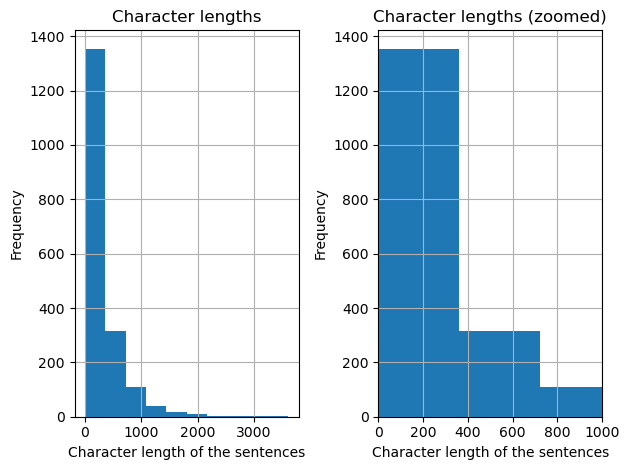

In [47]:
# Plot a histogram for that column
fig, axes = plt.subplots(1, 2)
df_cleaned.hist(column="length", ax=axes[0])
axes[0].set_title('Character lengths')
axes[0].set(xlabel="Character length of the sentences", ylabel="Frequency")

df_cleaned.hist(column="length", ax=axes[1])

axes[1].set_title('Character lengths (zoomed)')
axes[1].set(xlabel="Character length of the sentences", ylabel="Frequency", xlim = [0, 1000])
fig.tight_layout()

Define a cutoff for the sentences. All sentences belows this length will be removed

In [48]:
cut_len = 30

Create a smaller dataframe, and export it to csv, that only contains the short length sentences.
Check the csv and change the length condition accordingly.

In [49]:
# testing_df = df[df['length'] < cut_len]
# testing_df = testing_df.sort_values(by=['length'], ascending=False)

In [50]:
# testing_df.head(10)

In [51]:
# # Uncomment the following line of code to create the csv which contains the short length sentences.
# testing_df.to_csv(f"{year}_len_{cut_len}_testing.csv", index=False)

<br>
Once, the length is decided, create a new dataframe with sentences greater that the length

In [52]:
# Initial length
ilen = df_cleaned.shape[0]

In [53]:
df_cleaned = df_cleaned[ df_cleaned["length"] > cut_len]
print("Length of the cleaned dataframe: ", df_cleaned.shape[0])
print("Reduction of about {:.2f}%".format( (1 - df_cleaned.shape[0]/ilen) * 100))

Length of the cleaned dataframe:  1359
Reduction of about 26.82%


In [54]:
df_cleaned.reset_index(drop=True, inplace=True)
df_cleaned.index.name = "index"

# Rearrange columns
cols = df_cleaned.columns.tolist()
cols = [cols[0]] + cols[-1:] + cols[1:-1]
df_cleaned = df_cleaned[cols]

In [55]:
df_cleaned

,org_sent,length,start_page,end_page,removed
index,,,,,
0,AN ACT TO GRANT TO THE CITY COUNCIL OF CHARLESTON AND ITS SUCCESSORS THE TITLE AND INTEREST OF THE STATE TO CERTAIN LANDS IN CHARLESTON COUNTY FOR THE PURPOSES OF A NAVAL STATION.,179,00035,00035,344.
1,"Be it enacted by the General Assembly of the State of South Carolina : That the right, title and interest of the State to the following described tract or parcel of land and land covered with water situated in the County of Charleston in this State be, and the same is hereby granted and ceded to “All that the City Council of Charleston and its successors: tract or parcel of land and land covered with water situate lying and being on the west bank of the Cooper River, in the County of Charleston in this State; measuring and containing seven hundred and sixty acres more or less, butting and bounding to the North by lands of Mrs. W. W. Lawton and by the Cooper River, on the East by Cooper River, on the South by Ship Yard Creek and on the West by Ship Yard Creek, as is delineated on a map of the city of Charleston and vicinity made by J. H. Dingle, City Surveyor, December 1900.”",888,00035,00036,SECTION 1. ; SEc. 2.; - ; -
2,"The grant herein made is upon the express condition that the City Council of Charleston shall convey, in fee simple to the United States of America, the said tract or parcel of land hereinbefore referred to in Section 1 of this Act for the site, location and purposes of a naval station.",287,00036,00036,-
3,"That in case of the failure of the United States of America to locate, build or construct a Naval Station in the County of Charleston within the space of three years from the passage of this Act, then the title to said tract or parcel of land shall revert to the State.",269,00036,00036,NaN
4,"That this Act shall take effect immediately upon its approval by the Governor. Approved the 8th day of February, A. D. Igor.",125,00036,00036,NaN
...,...,...,...,...,...
1354,"nds adjacent to said River; And whereas by the construction of said dam or dams the navigation of said River may be increased and the public interest promoted by the construction thereof for the purpose and for the sake of such improvement in the navigability of said River and for the public purposes to be ,fulfilled and encouraged by the construction of said dam or dams and for the purpose of removing any doubt which may arise as to the power and authority of the Secretary of State in granting the charter to the said Twin City Power Company for the erection of said dam or dams to be built across the said River: Now, Section 1. Be it enacted by the General Assembly of the State of South Carolina: That the right, power and privilege to construct and maintain a dam or dams across the Savannah River, as hereinbefore mentioned, to Twin City Power Company, its successors or assigns, shall be and is hereby fully authorized, ratified and confirmed; and that the said Twin City Power Company shall have all rights, powers and privileges conferred for the purpose of the acquisition and condemnation of land which may be overflowed by the erection or construction of said dam or dams as are conferred by Sections 1743-1755, inclusive, of the Revised Statutes of South Carolina, 1893, upon railway, canal and turnpike companies in the State and all of the Acts amendatory thereof; it being the intention of this Act for the sake of the public purposes intended to be carried out by said company to confer upon it all the rights, privileges and authorities conferred by the laws of this State upon railway, canal and turnpike companies in the acquisition and condemnation of property for rights of way or other interests in lands. Approved the 2oth day of February, A. D. 1901",1780,00291,00291,- ; - ; - ; - ; - ; - ; - ; - ; la
1355,AN ACT TO EMPOWER AND AUTHORIZE THE COUNNTY BOARD OF COMMISSIONERS OF CHEROKEE COUNTY TO BUILD A BRIDGE ACROSS BROAAD RIVER AND BORROW MONEY THEREFOR FROM THE COMMISSIONERS OF THE SINK

<br>

## F. Adding features
The features added below are:
- an id: a concatenation of the year and index number
- whether the sentence is an Act or a Joint
- the state that the law originates from

<br>

### 1. Adding ID

In [56]:
def addPrefix(fileName: str, nameLen: int, fileType: bool) -> str:
    '''
    Since the fileNames from the excel parsing could be any of any length
    (ranging from 1-3), this function appends a string of 0's to the 
    start of the input so that it is the specified nameLen lengths long.
    
    Parameters
    ----------
    fileName : str
        The file name that needs to be prefixed
    nameLen : int
        The length of the expected name of the file
        Ex. '00034.jpg' would have length of 5
        so nameLen should be 5
    fileType: bool
        True if the fileName contains a fileType prefix such as '.tiff'

    Returns
    -------
    str
        A length 5 file name (prefixed with 0's)
    '''
    
    # Remove the file type
    if fileType:
        name = fileName.split(".")[0]
    else:
        name = fileName

    prefix_length = nameLen - len(name)
    prefix = "0" * prefix_length
    
    final_string = prefix + fileName
    return final_string

In [57]:
df_cleaned.reset_index(inplace=True)
df_cleaned.rename(columns={"index" : "id"}, inplace=True)

In [58]:
# The length of the id of the last row in the dataframe, which is used to assess how many 0's will be prefixed to the other ids
maxNumLength = len(str(df_cleaned.last_valid_index()))

for i in range(0, df_cleaned.shape[0]):
    df_cleaned.at[i, 'id'] = str(year) + "_" + addPrefix(str(df_cleaned.iloc[i]['id']), maxNumLength, fileType=False)

In [59]:
df_cleaned

,id,org_sent,length,start_page,end_page,removed
0,1901_0000,AN ACT TO GRANT TO THE CITY COUNCIL OF CHARLESTON AND ITS SUCCESSORS THE TITLE AND INTEREST OF THE STATE TO CERTAIN LANDS IN CHARLESTON COUNTY FOR THE PURPOSES OF A NAVAL STATION.,179,00035,00035,344.
1,1901_0001,"Be it enacted by the General Assembly of the State of South Carolina : That the right, title and interest of the State to the following described tract or parcel of land and land covered with water situated in the County of Charleston in this State be, and the same is hereby granted and ceded to “All that the City Council of Charleston and its successors: tract or parcel of land and land covered with water situate lying and being on the west bank of the Cooper River, in the County of Charleston in this State; measuring and containing seven hundred and sixty acres more or less, butting and bounding to the North by lands of Mrs. W. W. Lawton and by the Cooper River, on the East by Cooper River, on the South by Ship Yard Creek and on the West by Ship Yard Creek, as is delineated on a map of the city of Charleston and vicinity made by J. H. Dingle, City Surveyor, December 1900.”",888,00035,00036,SECTION 1. ; SEc. 2.; - ; -
2,1901_0002,"The grant herein made is upon the express condition that the City Council of Charleston shall convey, in fee simple to the United States of America, the said tract or parcel of land hereinbefore referred to in Section 1 of this Act for the site, location and purposes of a naval station.",287,00036,00036,-
3,1901_0003,"That in case of the failure of the United States of America to locate, build or construct a Naval Station in the County of Charleston within the space of three years from the passage of this Act, then the title to said tract or parcel of land shall revert to the State.",269,00036,00036,NaN
4,1901_0004,"That this Act shall take effect immediately upon its approval by the Governor. Approved the 8th day of February, A. D. Igor.",125,00036,00036,NaN
...,...,...,...,...,...,...
1354,1901_1354,"nds adjacent to said River; And whereas by the construction of said dam or dams the navigation of said River may be increased and the public interest promoted by the construction thereof for the purpose and for the sake of such improvement in the navigability of said River and for the public purposes to be ,fulfilled and encouraged by the construction of said dam or dams and for the purpose of removing any doubt which may arise as to the power and authority of the Secretary of State in granting the charter to the said Twin City Power Company for the erection of said dam or dams to be built across the said River: Now, Section 1. Be it enacted by the General Assembly of the State of South Carolina: That the right, power and privilege to construct and maintain a dam or dams across the Savannah River, as hereinbefore mentioned, to Twin City Power Company, its successors or assigns, shall be and is hereby fully authorized, ratified and confirmed; and that the said Twin City Power Company shall have all rights, powers and privileges conferred for the purpose of the acquisition and condemnation of land which may be overflowed by the erection or construction of said dam or dams as are conferred by Sections 1743-1755, inclusive, of the Revised Statutes of South Carolina, 1893, upon railway, canal and turnpike companies in the State and all of the Acts amendatory thereof; it being the intention of this Act for the sake of the public purposes intended to be carried out by said company to confer upon it all the rights, privileges and authorities conferred by the laws of this State upon railway, canal and turnpike companies in the acquisition and condemnation of property for rights of way or other interests in lands. Approved the 2oth day of February, A. D. 1901",1780,00291,00291,- ; - ; - ; - ; - ; - ; - ; - ; la
1355,1901_1355,AN ACT TO EMPOWER AND AUTHORIZE THE COUNNTY BOARD OF COMMISSIONERS OF CHEROKEE COUNTY TO BUILD A BRIDGE ACROSS BROAAD 

<br>

### 2. Adding the remaining identifiers

In [60]:
df_cleaned.insert(1, 'law_type', 'Acts')
df_cleaned.insert(2, 'state', 'SOUTH CAROLINA')

<br>

## Exporting

In [62]:
# Drop the 'removed' column
df_cleaned.drop(['removed'], axis = 1, inplace=True)

# Rename the 'org_sent' column
df_cleaned.rename(columns={"org_sent": "sentence"}, inplace=True)

df_cleaned

,id,law_type,state,sentence,length,start_page,end_page
0,1901_0000,Acts,SOUTH CAROLINA,AN ACT TO GRANT TO THE CITY COUNCIL OF CHARLESTON AND ITS SUCCESSORS THE TITLE AND INTEREST OF THE STATE TO CERTAIN LANDS IN CHARLESTON COUNTY FOR THE PURPOSES OF A NAVAL STATION.,179,00035,00035
1,1901_0001,Acts,SOUTH CAROLINA,"Be it enacted by the General Assembly of the State of South Carolina : That the right, title and interest of the State to the following described tract or parcel of land and land covered with water situated in the County of Charleston in this State be, and the same is hereby granted and ceded to “All that the City Council of Charleston and its successors: tract or parcel of land and land covered with water situate lying and being on the west bank of the Cooper River, in the County of Charleston in this State; measuring and containing seven hundred and sixty acres more or less, butting and bounding to the North by lands of Mrs. W. W. Lawton and by the Cooper River, on the East by Cooper River, on the South by Ship Yard Creek and on the West by Ship Yard Creek, as is delineated on a map of the city of Charleston and vicinity made by J. H. Dingle, City Surveyor, December 1900.”",888,00035,00036
2,1901_0002,Acts,SOUTH CAROLINA,"The grant herein made is upon the express condition that the City Council of Charleston shall convey, in fee simple to the United States of America, the said tract or parcel of land hereinbefore referred to in Section 1 of this Act for the site, location and purposes of a naval station.",287,00036,00036
3,1901_0003,Acts,SOUTH CAROLINA,"That in case of the failure of the United States of America to locate, build or construct a Naval Station in the County of Charleston within the space of three years from the passage of this Act, then the title to said tract or parcel of land shall revert to the State.",269,00036,00036
4,1901_0004,Acts,SOUTH CAROLINA,"That this Act shall take effect immediately upon its approval by the Governor. Approved the 8th day of February, A. D. Igor.",125,00036,00036
...,...,...,...,...,...,...,...
1354,1901_1354,Acts,SOUTH CAROLINA,"nds adjacent to said River; And whereas by the construction of said dam or dams the navigation of said River may be increased and the public interest promoted by the construction thereof for the purpose and for the sake of such improvement in the navigability of said River and for the public purposes to be ,fulfilled and encouraged by the construction of said dam or dams and for the purpose of removing any doubt which may arise as to the power and authority of the Secretary of State in granting the charter to the said Twin City Power Company for the erection of said dam or dams to be built across the said River: Now, Section 1. Be it enacted by the General Assembly of the State of South Carolina: That the right, power and privilege to construct and maintain a dam or dams across the Savannah River, as hereinbefore mentioned, to Twin City Power Company, its successors or assigns, shall be and is hereby fully authorized, ratified and confirmed; and that the said Twin City Power Company shall have all rights, powers and privileges conferred for the purpose of the acquisition and condemnation of land which may be overflowed by the erection or construction of said dam or dams as are conferred by Sections 1743-1755, inclusive, of the Revised Statutes of South Carolina, 1893, upon railway, canal and turnpike companies in the State and all of the Acts amendatory thereof; it being the intention of this Act for the sake of the public purposes intended to be carried out by said company to confer upon it all the rights, privileges and authorities conferred by the laws of this State upon railway, canal and turnpike companies in the acquisition and condemnation of property for rights of way or other interests in lands. Approved the 2oth day of February, A. D. 1901",1780,00291,00291
1355,1901_1355,Acts,SOUTH CAROLINA,AN ACT TO EMPOWER AND AUTHORIZE THE COUNNTY B

In [63]:
# # Export the final dataframe to csv for viewing
# df_cleaned.to_csv(f"{year}.csv", index=False)